DTW computation successful!


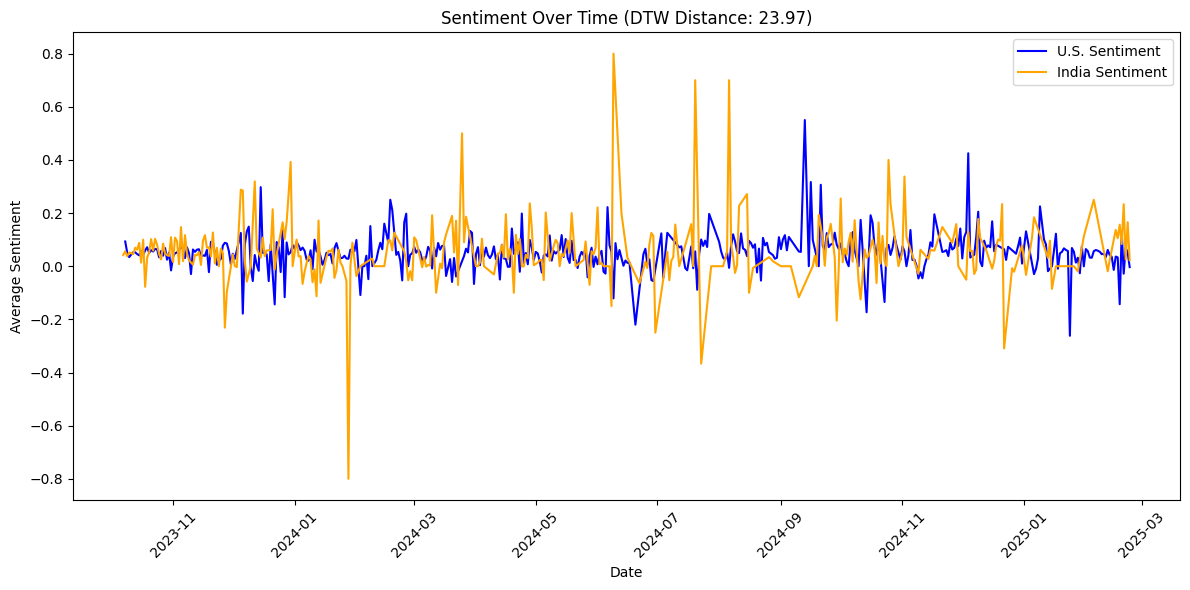

US data shape before cleaning: (34431, 11)
India data shape before cleaning: (7024, 11)
NaN values in US Text: 409
NaN values in India Text: 244
NaN values in US Text after cleaning: 0
NaN values in India Text after cleaning: 0


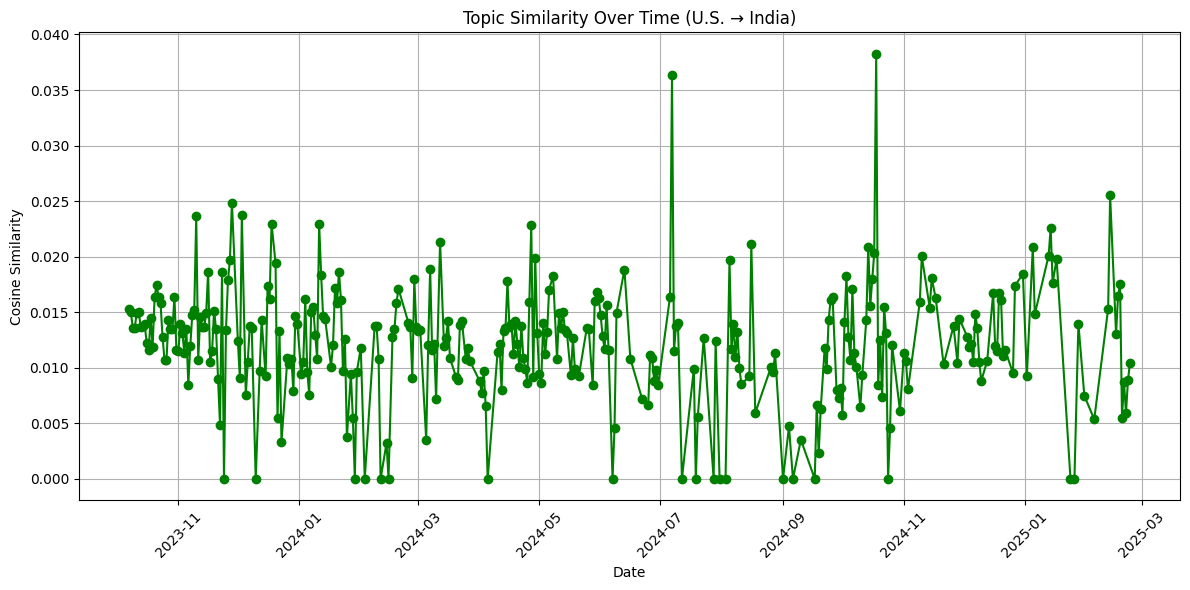

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load U.S. data (CSV)
us_data = pd.read_csv("/kaggle/input/usaaaaaaaaa/United_States_data.csv", encoding="utf-8")
# Load India data (Excel)
india_data = pd.read_excel("/kaggle/input/gaza-israel/India_data.xlsx", engine="openpyxl")

# Convert 'Date' column to datetime format in both U.S. and India data
us_data['Date'] = pd.to_datetime(us_data['Date'])
india_data['Date'] = pd.to_datetime(india_data['Date'])

# Aggregate data by day for time-series analysis
us_data['date'] = us_data['Date'].dt.date
india_data['date'] = india_data['Date'].dt.date

# ---- STEP 2: SENTIMENT ANALYSIS ----
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity  # Returns sentiment score between -1 and 1

us_data['sentiment'] = us_data['Text'].apply(get_sentiment)
india_data['sentiment'] = india_data['Text'].apply(get_sentiment)

# Aggregate sentiment scores by day
us_sentiment_by_date = us_data.groupby('date')['sentiment'].mean()
india_sentiment_by_date = india_data.groupby('date')['sentiment'].mean()

# ---- STEP 3: TEMPORAL RESPONSIVENESS ANALYSIS ----
# Convert sentiment time series to numpy arrays
us_sentiment_ts = np.array(us_sentiment_by_date.values).reshape(-1)
india_sentiment_ts = np.array(india_sentiment_by_date.values).reshape(-1)

# Convert to 1D arrays of floats
us_sentiment_values = np.array([float(x) for x in us_sentiment_ts]).reshape(-1)
india_sentiment_values = np.array([float(x) for x in india_sentiment_ts]).reshape(-1)

# Use Dynamic Time Warping (DTW) to measure lag effect
# Reshape for fastdtw
us_reshaped = us_sentiment_values.reshape(-1, 1)  # Each value becomes a 1D point
india_reshaped = india_sentiment_values.reshape(-1, 1)

# Now use fastdtw with reshaped data
try:
    distance, path = fastdtw(us_reshaped, india_reshaped, dist=euclidean)
    print("DTW computation successful!")
except Exception as e:
    print(f"Error in fastdtw: {e}")
    distance = 0
    path = []

# Get dates for plotting
us_dates = us_sentiment_by_date.index
india_dates = india_sentiment_by_date.index

# Plot sentiment over time using original data
plt.figure(figsize=(12, 6))
plt.plot(us_dates, us_sentiment_by_date.values, label="U.S. Sentiment", color="blue")
plt.plot(india_dates, india_sentiment_by_date.values, label="India Sentiment", color="orange")
plt.title(f"Sentiment Over Time (DTW Distance: {distance:.2f})")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- STEP 4: TEXTUAL SIMILARITY ANALYSIS ----
# First, handle NaN values in the text columns
print(f"US data shape before cleaning: {us_data.shape}")
print(f"India data shape before cleaning: {india_data.shape}")

# Check for and report NaN values
print(f"NaN values in US Text: {us_data['Text'].isna().sum()}")
print(f"NaN values in India Text: {india_data['Text'].isna().sum()}")

# Replace NaN values with empty strings
us_data['Text'] = us_data['Text'].fillna("")
india_data['Text'] = india_data['Text'].fillna("")

# Double-check after cleaning
print(f"NaN values in US Text after cleaning: {us_data['Text'].isna().sum()}")
print(f"NaN values in India Text after cleaning: {india_data['Text'].isna().sum()}")

# Convert text to TF-IDF vectors to compare topic similarity
vectorizer = TfidfVectorizer(stop_words='english')
us_vectors = vectorizer.fit_transform(us_data['Text'])
india_vectors = vectorizer.transform(india_data['Text'])  # Use same vocabulary

# Compute cosine similarity between U.S. and India topics
similarity_scores = cosine_similarity(us_vectors, india_vectors)

# Find average similarity per day
avg_similarity_per_day = []
for date in india_data['date'].unique():
    india_texts = india_data[india_data['date'] == date]['Text']
    if len(india_texts) > 0:
        india_vectors = vectorizer.transform(india_texts)
        similarity_score = cosine_similarity(us_vectors, india_vectors).mean()
        avg_similarity_per_day.append((date, similarity_score))

# Convert to DataFrame
similarity_df = pd.DataFrame(avg_similarity_per_day, columns=["date", "similarity"])
similarity_df.sort_values("date", inplace=True)

# ---- STEP 5: PLOT TOPIC SIMILARITY ----
plt.figure(figsize=(12, 6))
plt.plot(similarity_df["date"], similarity_df["similarity"], color="green", marker="o")
plt.title("Topic Similarity Over Time (U.S. → India)")
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Topic 1: voters, us, harris, people, would, vote, israel, gaza, biden, trump
Topic 2: civilian, war, palestinians, israeli, west, bank, civilians, gaza, israel, hamas
Topic 3: indian, supporting, palestinians, terrorist, support, people, israel, india, palestine, hamas
Topic 4: civilians, palestinians, hostages, would, gaza, people, war, genocide, hamas, israel
Topic 5: like, jewish, palestinians, palestine, people, us, would, jews, state, israel


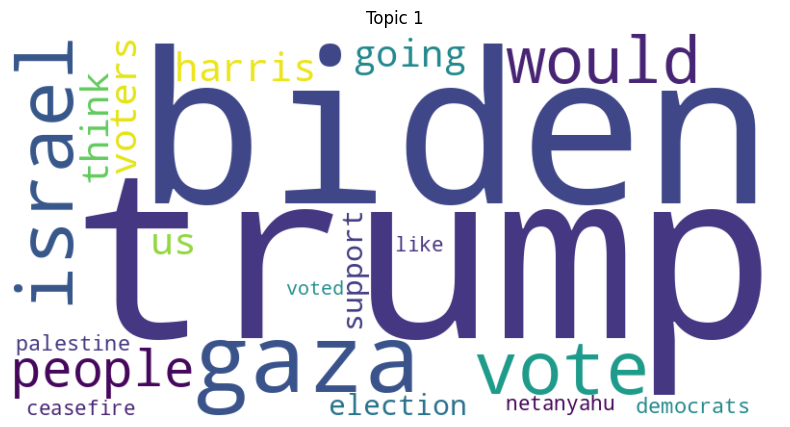

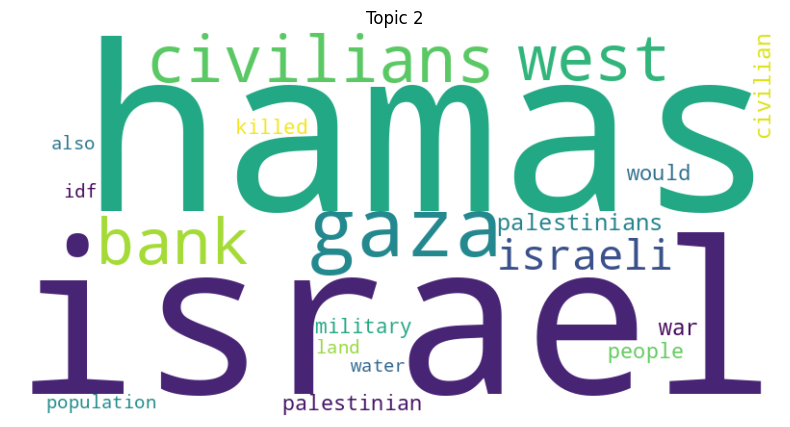

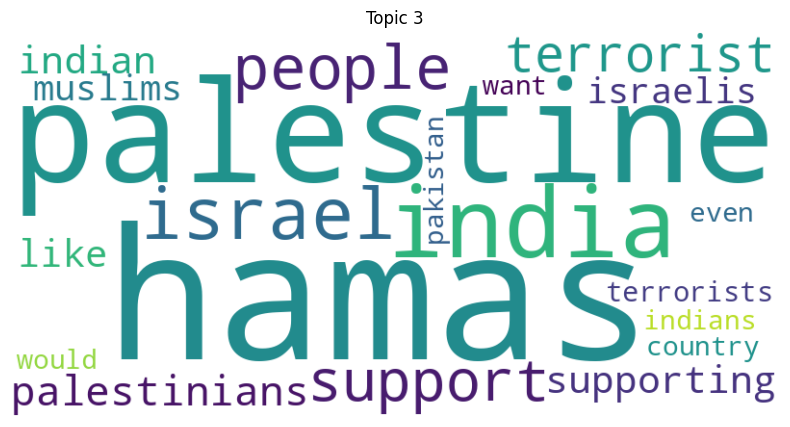

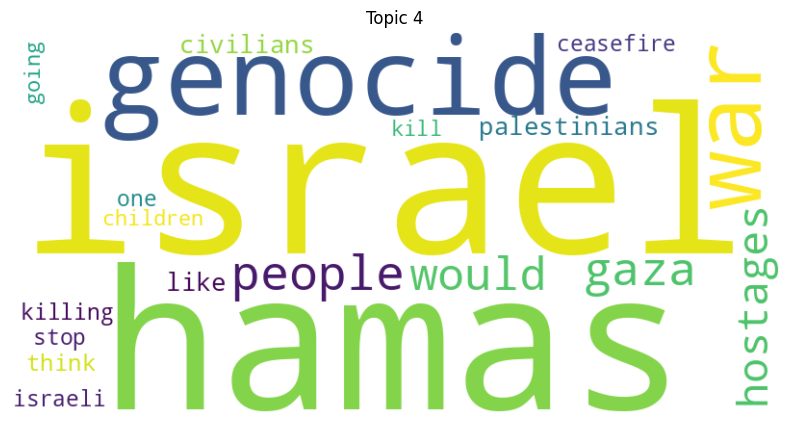

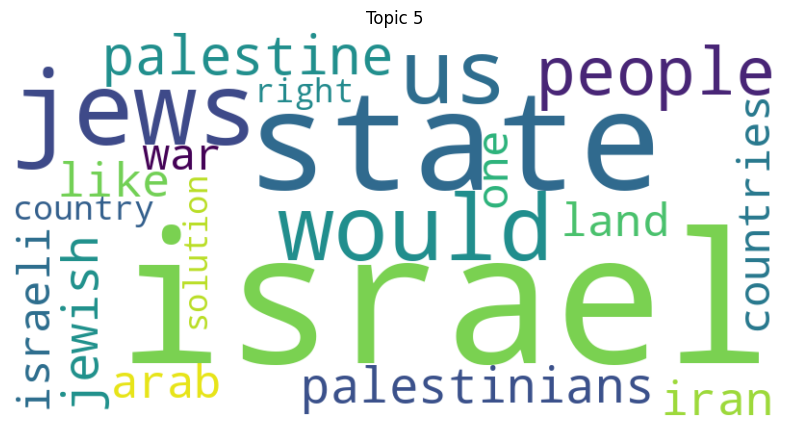

Topic assignments saved to '/kaggle/working/texts_with_topics.csv'


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download NLTK resources (Kaggle has these pre-installed, but ensure they're ready)
nltk.download('punkt')
nltk.download('stopwords')

# Load data with appropriate readers
files = [
    '/kaggle/input/gaza-israel/Jordan_data.xlsx',
    '/kaggle/input/gaza-israel/India_data.xlsx',
    '/kaggle/input/gaza-israel/Egypt_data.xlsx',
    '/kaggle/input/usaaaaaaaaa/United_States_data.csv'
]

# Read files based on extension
df_list = []
for file in files:
    if file.endswith('.xlsx'):
        df_list.append(pd.read_excel(file))
    elif file.endswith('.csv'):
        # Try UTF-8, fall back to latin1 if it fails
        try:
            df_list.append(pd.read_csv(file, encoding='utf-8'))
        except UnicodeDecodeError:
            df_list.append(pd.read_csv(file, encoding='latin1'))

# Combine dataframes
df = pd.concat(df_list, ignore_index=True)

# Filter to text data and drop NaN
texts = df['Text'].dropna().astype(str)

# Preprocessing function
stop_words = set(stopwords.words('english') + ['http', 'https', 'www', 'com', 'reddit'])
def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
cleaned_texts = texts.apply(preprocess)

# Vectorize text with TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.95)
X = vectorizer.fit_transform(cleaned_texts)

# Apply LDA
n_topics = 5  # Adjust as needed
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# Display top words per topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

# Visualize with word clouds
for topic_idx, topic in enumerate(lda.components_):
    word_weights = {feature_names[i]: topic[i] for i in topic.argsort()[-20:]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_idx + 1}')
    plt.savefig(f'/kaggle/working/topic_{topic_idx + 1}_wordcloud.png')
    plt.show()

# Assign topics to each document
topic_distributions = lda.transform(X)
df_texts = pd.DataFrame({'Text': texts, 'Cleaned_Text': cleaned_texts})
df_texts['Dominant_Topic'] = topic_distributions.argmax(axis=1) + 1
df_texts.to_csv('/kaggle/working/texts_with_topics.csv', index=False)
print("Topic assignments saved to '/kaggle/working/texts_with_topics.csv'")

Error fetching news data from Mediastack: 401 Client Error: Unauthorized for url: http://api.mediastack.com/v1/news?access_key=YOUR_MEDIASTACK_API_KEY&keywords=Israel+Palestine+Gaza+Hamas+ceasefire&date=2023-10-07%2C2024-04-04&languages=en&sort=published_desc&limit=100
Error fetching news data from Mediastack: 401 Client Error: Unauthorized for url: http://api.mediastack.com/v1/news?access_key=YOUR_MEDIASTACK_API_KEY&keywords=Israel+Palestine+Gaza+Hamas+ceasefire&date=2023-10-07%2C2024-04-04&languages=en&sort=published_desc&limit=100


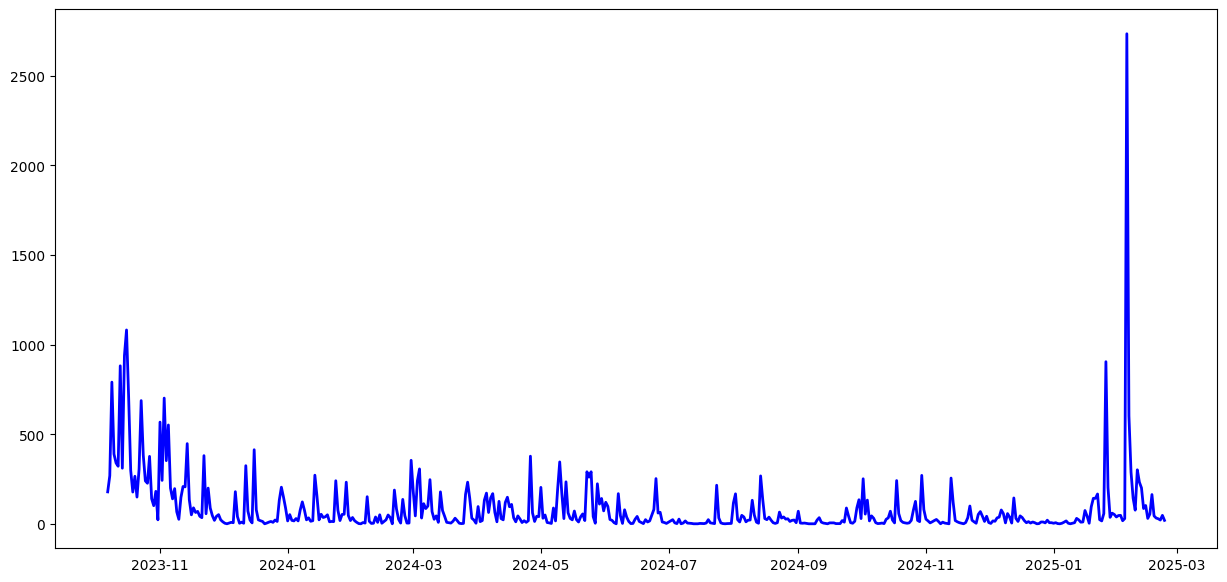

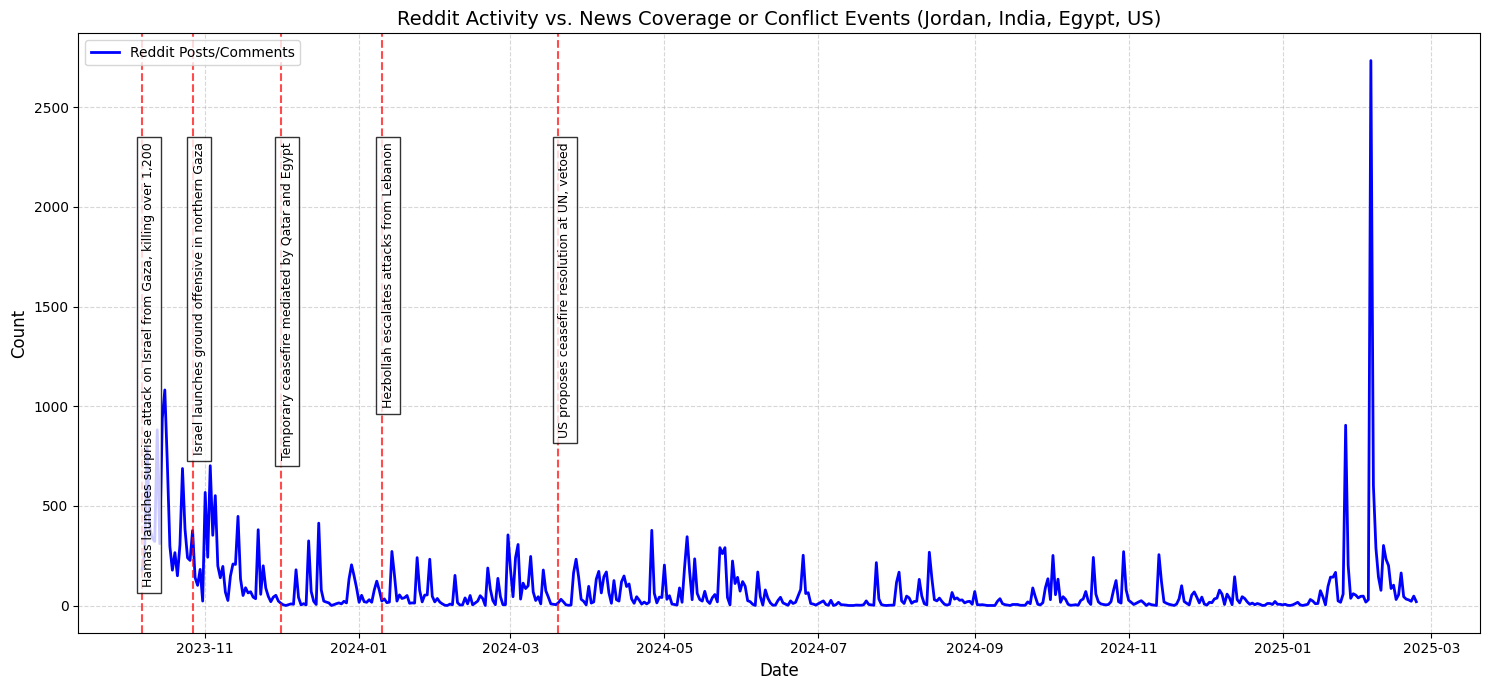

Merged data saved to '/kaggle/working/reddit_news_or_events_merged.csv'


In [6]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime

# Load Reddit data from Kaggle input paths
files = [
    '/kaggle/input/gaza-israel/Jordan_data.xlsx',
    '/kaggle/input/gaza-israel/India_data.xlsx',
    '/kaggle/input/gaza-israel/Egypt_data.xlsx',
    '/kaggle/input/usaaaaaaaaa/United_States_data.csv'
]

# Read files with appropriate methods and encoding handling
df_list = []
for file in files:
    try:
        if file.endswith('.xlsx'):
            df_list.append(pd.read_excel(file))
        elif file.endswith('.csv'):
            try:
                df_list.append(pd.read_csv(file, encoding='utf-8'))
            except UnicodeDecodeError:
                df_list.append(pd.read_csv(file, encoding='latin1'))
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine dataframes
df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.date  # Handle invalid dates

# Aggregate Reddit post/comment counts by date
daily_counts = df.groupby('Date').size().reset_index(name='Reddit_Count')

# Mediastack API setup (free tier: 100 requests/month, historical data up to 1 year)
# Sign up at https://mediastack.com/ for a free API key
api_key = 'YOUR_MEDIASTACK_API_KEY'  # Replace with your Mediastack key
url = 'http://api.mediastack.com/v1/news'  # HTTP endpoint (not HTTPS for free tier)
params = {
    'access_key': api_key,
    'keywords': 'Israel Palestine Gaza Hamas ceasefire',
    'date': '2023-10-07,2024-04-04',  # Free tier limited to 1 year back; adjust to current date when running
    'languages': 'en',
    'sort': 'published_desc',
    'limit': 100  # Max per request in free tier
}

# Fetch news data from Mediastack
try:
    response = requests.get(url, params=params)
    response.raise_for_status()  # Check for HTTP errors
    news_data = response.json()
    if 'data' in news_data:
        news_df = pd.DataFrame(news_data['data'])
        news_df['published_at'] = pd.to_datetime(news_df['published_at']).dt.date
        news_counts = news_df.groupby('published_at').size().reset_index(name='News_Count')
    else:
        raise ValueError("No 'data' key in response")
except Exception as e:
    print(f"Error fetching news data from Mediastack: {e}")
    # Fallback to manual timeline if API fails
    events = [
        {'Date': '2023-10-07', 'Event': 'Hamas launches surprise attack on Israel from Gaza, killing over 1,200'},
        {'Date': '2023-10-27', 'Event': 'Israel launches ground offensive in northern Gaza'},
        {'Date': '2023-12-01', 'Event': 'Temporary ceasefire mediated by Qatar and Egypt'},
        {'Date': '2024-01-10', 'Event': 'Hezbollah escalates attacks from Lebanon'},
        {'Date': '2024-03-20', 'Event': 'US proposes ceasefire resolution at UN, vetoed'}
    ]
    news_counts = pd.DataFrame()  # Empty news counts triggers manual timeline
    events_df = pd.DataFrame(events)
    events_df['Date'] = pd.to_datetime(events_df['Date']).dt.date

# Merge Reddit and news data
if not news_counts.empty:
    merged_df = daily_counts.merge(news_counts, left_on='Date', right_on='published_at', how='outer').fillna(0)
    if 'published_at' in merged_df.columns:
        merged_df = merged_df.drop(columns=['published_at'])
else:
    merged_df = daily_counts.merge(events_df, on='Date', how='left')

# Visualize
plt.figure(figsize=(15, 7))
plt.plot(merged_df['Date'], merged_df['Reddit_Count'], label='Reddit Posts/Comments', color='blue', linewidth=2)

if not news_counts.empty:
    # Plot news counts if API succeeded
    plt.plot(merged_df['Date'], merged_df['News_Count'], label='News Articles (Mediastack)', color='red', linewidth=2)
else:
    # Add event markers if using manual timeline
  import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime

# Load Reddit data from Kaggle input paths
files = [
    '/kaggle/input/gaza-israel/Jordan_data.xlsx',
    '/kaggle/input/gaza-israel/India_data.xlsx',
    '/kaggle/input/gaza-israel/Egypt_data.xlsx',
    '/kaggle/input/usaaaaaaaaa/United_States_data.csv'
]

# Read files with appropriate methods and encoding handling
df_list = []
for file in files:
    try:
        if file.endswith('.xlsx'):
            df_list.append(pd.read_excel(file))
        elif file.endswith('.csv'):
            try:
                df_list.append(pd.read_csv(file, encoding='utf-8'))
            except UnicodeDecodeError:
                df_list.append(pd.read_csv(file, encoding='latin1'))
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine dataframes
df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.date  # Handle invalid dates

# Aggregate Reddit post/comment counts by date
daily_counts = df.groupby('Date').size().reset_index(name='Reddit_Count')

# Mediastack API setup (free tier: 100 requests/month, historical data up to 1 year)
# Sign up at https://mediastack.com/ for a free API key
api_key = 'YOUR_MEDIASTACK_API_KEY'  # Replace with your Mediastack key
url = 'http://api.mediastack.com/v1/news'  # HTTP endpoint (not HTTPS for free tier)
params = {
    'access_key': api_key,
    'keywords': 'Israel Palestine Gaza Hamas ceasefire',
    'date': '2023-10-07,2024-04-04',  # Free tier limited to 1 year back; adjust to current date when running
    'languages': 'en',
    'sort': 'published_desc',
    'limit': 100  # Max per request in free tier
}

# Fetch news data from Mediastack
try:
    response = requests.get(url, params=params)
    response.raise_for_status()  # Check for HTTP errors
    news_data = response.json()
    if 'data' in news_data:
        news_df = pd.DataFrame(news_data['data'])
        news_df['published_at'] = pd.to_datetime(news_df['published_at']).dt.date
        news_counts = news_df.groupby('published_at').size().reset_index(name='News_Count')
    else:
        raise ValueError("No 'data' key in response")
except Exception as e:
    print(f"Error fetching news data from Mediastack: {e}")
    # Fallback to manual timeline if API fails
    events = [
        {'Date': '2023-10-07', 'Event': 'Hamas launches surprise attack on Israel from Gaza, killing over 1,200'},
        {'Date': '2023-10-27', 'Event': 'Israel launches ground offensive in northern Gaza'},
        {'Date': '2023-12-01', 'Event': 'Temporary ceasefire mediated by Qatar and Egypt'},
        {'Date': '2024-01-10', 'Event': 'Hezbollah escalates attacks from Lebanon'},
        {'Date': '2024-03-20', 'Event': 'US proposes ceasefire resolution at UN, vetoed'}
    ]
    news_counts = pd.DataFrame()  # Empty news counts triggers manual timeline
    events_df = pd.DataFrame(events)
    events_df['Date'] = pd.to_datetime(events_df['Date']).dt.date

# Merge Reddit and news data
if not news_counts.empty:
    merged_df = daily_counts.merge(news_counts, left_on='Date', right_on='published_at', how='outer').fillna(0)
    if 'published_at' in merged_df.columns:
        merged_df = merged_df.drop(columns=['published_at'])
else:
    merged_df = daily_counts.merge(events_df, on='Date', how='left')

# Visualize
plt.figure(figsize=(15, 7))
plt.plot(merged_df['Date'], merged_df['Reddit_Count'], label='Reddit Posts/Comments', color='blue', linewidth=2)

if not news_counts.empty:
    # Plot news counts if API succeeded
    plt.plot(merged_df['Date'], merged_df['News_Count'], label='News Articles (Mediastack)', color='red', linewidth=2)
else:
    # Add event markers if using manual timeline
    for event_date, event in events_df.itertuples(index=False):
        plt.axvline(x=event_date, color='red', linestyle='--', alpha=0.7)
        y_pos = merged_df['Reddit_Count'].max() * 0.85 if merged_df['Reddit_Count'].max() > 50 else 50
        plt.text(event_date, y_pos, event, rotation=90, verticalalignment='top', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

plt.title('Reddit Activity vs. News Coverage or Conflict Events (Jordan, India, Egypt, US)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('/kaggle/working/reddit_news_or_events_timeline.png', dpi=300)
plt.show()

# Save merged data
merged_df.to_csv('/kaggle/working/reddit_news_or_events_merged.csv', index=False)
print("Merged data saved to '/kaggle/working/reddit_news_or_events_merged.csv'")  